# midinetwモデルの学習
midinetwはmidinet2をベースにWasserstein GAN-gpで学習を行うもの  
でもセクションベクトルはあんまり意味ないみたいなので使わない  
  
特徴マップは， Gの出力とrealの差を考慮する奴には効果があることがわかったので使う    
これは学習の初期段階でGの学習率を大きくすることに相当する効果がある模様  
学習率を一定で大きくしてしまうとDに思いっきり見破られてしまう  
色々とGANの実験をやってみてわかったのは，GANの難しいところは必要な学習率が変動することにあるということ  
  
今になって気づいたけど，メロディの時系列が右に進むのに対して，コード条件はチャネル方向に進むのね  
そりゃちょっと違うわ  

In [1]:
import os, time, glob, ipdb, pickle, numpy as np
visible_devices = [2, 3]
os.environ['CUDA_VISIBLE_DEVICES'] = ','.join([str(i) for i in visible_devices])

import torch, torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
import torch.nn.functional as F
from torch.nn.functional import relu, leaky_relu
from torch.utils.data import DataLoader
from multi_gpu import MultiGPUWrapper
from PIL import Image
from utils import Timer, get_model, count_params
from IPython.display import clear_output

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
base_dir = "../datasets/theorytab/midinet"
input_data_path = os.path.join(base_dir, "midinetw.pkl")
output_dir = f"{base_dir}/learning"

if not os.path.isdir(output_dir):
    os.mkdir(output_dir)

## DataLoaderの作成

In [3]:
class MidinetDataset():
    def __init__(self, data_path, pitch_range=[0, 64], show_shape=False):
        data = pickle.load(open(data_path,'rb'))
        
        melody, prev, chord = [], [], []
        for m, p, c in data:
            melody.append(m)
            prev.append(p)
            chord.append(c)
        
        self.size = len(melody)
        steps = len(melody[0])
        bottom, top = pitch_range
        
        melody = np.array(melody)[:,:,bottom:top].reshape(self.size, 1, steps, top-bottom)
        prev = np.array(prev)[:,:,bottom:top].reshape(self.size, 1, steps, top-bottom)
        chord = np.array(chord)
        
        if show_shape:
            print("melody shape", melody.shape)
            print("prev shape", prev.shape)
            print("condition shape", chord.shape)
        
        self.x = torch.from_numpy(melody).float()
        self.prev_x   = torch.from_numpy(prev).float()
        self.y  = torch.from_numpy(chord).float()

    def __getitem__(self, index):
        return self.x[index], self.prev_x[index], self.y[index]

    def __len__(self):
        return self.size

In [4]:
def get_dataloader(data_path, batch_size=72, shuffle=True):
    dataset = MidinetDataset(data_path)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    print('Data loading is completed.')
    print(f'{len(dataloader)} batches from {len(dataset)} bars are obtained.')
    return dataloader

動作確認用のDataLoader

In [5]:
with Timer():
    dataloader = get_dataloader(input_data_path, batch_size=2)

Data loading is completed.
42964 batches from 85927 bars are obtained.
1.621849


## Modelの作成

model用共通関数の作成

In [5]:
def concat_vector(x, y):
    x_0, _, x_2, x_3 = x.shape               # 72, 1, 48, 64
    y2 = y.expand(x_0, y.shape[1], x_2, x_3) # 72, 48, 1, 1 -> 72, 48, 48, 64
    return torch.cat((x, y2),1)             # 72, 49, 48, 64
    
def batch_norm(x, eps=1e-05, momentum=0.9, affine=False):
    device = x.device
    if x.ndim == 2 or x.ndim == 3:
        norm = nn.BatchNorm1d(x.shape[1], eps=eps, momentum=momentum, affine=affine).to(device)
        return norm(x)
    elif x.ndim == 4:
        norm = nn.BatchNorm2d(x.shape[1], eps=eps, momentum=momentum, affine=affine).to(device)
        return norm(x)
    else:
        return x

def lrelu(x, slope=0.2):
    return leaky_relu(x, negative_slope=slope)

### Generator

forwardの入力
- z (batch, noise_size) = (72, 100): ランダムノイズ
- prev_x (batch, ch, steps, pitch) = (72, 1, 48, 64): 前の小節
- condition (batch, 48): 12次元×4の拍ごとの和音

forwardの出力
- g_x (batch, ch, steps, pitch)= (72, 1, 48, 64): 生成された今の小節

そういえば，なんでストライドが縦に2なのか？最初にpitch方向は1に潰してるから関係ないと思うけど

In [6]:
class Generator(nn.Module):
    def __init__(self, z_dim=100, pitch_range=64):
        super(Generator, self).__init__()
        self.z_dim   = z_dim
        self.y_dim   = 48
        
        self.prev_ch = 16
        self.gf_dim  = 128
        self.gfc_dim = 1024

        self.h1      = nn.ConvTranspose2d(in_channels=self.gf_dim+self.y_dim+self.prev_ch, out_channels=pitch_range, kernel_size=(2,1), stride=(2,2))
        self.h2      = nn.ConvTranspose2d(in_channels=pitch_range+self.y_dim+self.prev_ch, out_channels=pitch_range, kernel_size=(3,1), stride=(3,2))
        self.h3      = nn.ConvTranspose2d(in_channels=pitch_range+self.y_dim+self.prev_ch, out_channels=pitch_range, kernel_size=(2,1), stride=(2,2))
        self.h4      = nn.ConvTranspose2d(in_channels=pitch_range+self.y_dim+self.prev_ch, out_channels=pitch_range, kernel_size=(2,1), stride=(2,2))
        self.h5      = nn.ConvTranspose2d(in_channels=pitch_range+self.y_dim+self.prev_ch, out_channels=1, kernel_size=(1,pitch_range), stride=(1,2))

        self.h0_prev = nn.Conv2d(in_channels=1, out_channels=self.prev_ch, kernel_size=(1,pitch_range), stride=(1,2))
        self.h1_prev = nn.Conv2d(in_channels=self.prev_ch, out_channels=self.prev_ch, kernel_size=(2,1), stride=(2,2))
        self.h2_prev = nn.Conv2d(in_channels=self.prev_ch, out_channels=self.prev_ch, kernel_size=(2,1), stride=(2,2))
        self.h3_prev = nn.Conv2d(in_channels=self.prev_ch, out_channels=self.prev_ch, kernel_size=(3,1), stride=(3,2))
        self.h4_prev = nn.Conv2d(in_channels=self.prev_ch, out_channels=self.prev_ch, kernel_size=(2,1), stride=(2,2))

        self.linear1 = nn.Linear(self.z_dim + self.y_dim, self.gfc_dim)
        self.linear2 = nn.Linear(self.gfc_dim + self.y_dim, self.gf_dim*2*1)

    def forward(self, z, prev_x, y):
        batch_size = len(z)
        
        h0_prev = lrelu(batch_norm(self.h0_prev(prev_x)))   # 72, 16, 48, 1 ピッチ方向の畳み込み
        h1_prev = lrelu(batch_norm(self.h1_prev(h0_prev)))  # 72, 16, 24, 1
        h2_prev = lrelu(batch_norm(self.h2_prev(h1_prev)))  # 72, 16, 12, 1
        h3_prev = lrelu(batch_norm(self.h3_prev(h2_prev)))  # 72, 16, 4, 1
        h4_prev = lrelu(batch_norm(self.h4_prev(h3_prev)))  # 72, 16, 2, 1

        yb = y.view(batch_size, self.y_dim, 1, 1)           # 72, 48, 1, 1

        z = torch.cat((z,y),1)                              # 72, 148

        h0 = lrelu(batch_norm(self.linear1(z)))             # 72, 1024
        h0 = torch.cat((h0,y),1)                            # 72, 1072

        h1 = lrelu(batch_norm(self.linear2(h0)))            # 72, 256
        h1 = h1.view(batch_size, self.gf_dim, 2, 1)         # 72, 128, 2, 1
        
        h1 = concat_vector(h1, yb)                          # 72, 174, 2, 1
        h1 = concat_vector(h1, h4_prev)                     # 72, 192, 2, 1

        h2 = lrelu(batch_norm(self.h1(h1)))                 # 72,  64, 4, 1 逆畳み込み． チャンネル数は固定で，3次元目が拡大される
        h2 = concat_vector(h2, yb)                          # 72, 112, 4, 1
        h2 = concat_vector(h2, h3_prev)                     # 72, 128, 4, 1

        h3 = lrelu(batch_norm(self.h2(h2)))                 # 72,  64, 12, 1 
        h3 = concat_vector(h3, yb)                          # 72, 112, 12, 1
        h3 = concat_vector(h3, h2_prev)                     # 72, 128, 12, 1

        h4 = lrelu(batch_norm(self.h3(h3)))                 # 72,  64, 24, 1
        h4 = concat_vector(h4, yb)                          # 72, 112, 24, 1
        h4 = concat_vector(h4, h1_prev)                     # 72, 128, 24, 1
        
        h5 = lrelu(batch_norm(self.h4(h4)))                 # 72,  64, 48, 1
        h5 = concat_vector(h5, yb)                          # 72, 112, 48, 1
        h5 = concat_vector(h5, h0_prev)                     # 72, 128, 48, 1

        h5 = self.h5(h5)                                    # 72, 1, 48, 64  ピッチ方向の逆畳み込み
        g_x = torch.sigmoid(h5)
        
        return g_x

動作確認

In [8]:
G = Generator()
print("parameters:", count_params(G))

x, prev_x, y = next(iter(dataloader))
z = torch.randn(2, G.z_dim)
g_out = G(z, prev_x, y)
print("real shape:", x.shape)
print("fake shape:", g_out.shape)

parameters: 521041
real shape: torch.Size([2, 1, 48, 64])
fake shape: torch.Size([2, 1, 48, 64])


### Discriminator
forwardの入力
- x (batch, 1, steps, pitch) = (72, 1, 48, 64): real/fake判定を行う小節データ
- prev_x (batch, 1, steps, pitch) = (72, 1, 48, 64): 前の小節データ
- y (batch, 48) = (72, 48): コードの条件データ

forwardの出力
- h4_sigmoid (batch, 1) = (72, 1): 0~1に押し込められたreal/fake判定結果．0はfake, 1はreal
- h4 (batch, 1) = (72, 1): 0~1に押し込められていないreal/fake判定結果

prev_xが識別に使われてなかったので今回は使うようにしよう

In [7]:
class Discriminator(nn.Module):
    def __init__(self, z_dim=100, pitch_range=64):
        super(Discriminator, self).__init__()
        self.y_dim = 48

        self.x_dim = 2      # +2はメロディと前小節メロディのチャネル
        self.df_dim = 64
        self.dfc_dim = 1024
        
        self.h0_prev = nn.Conv2d(
            in_channels=self.y_dim + self.x_dim,
            out_channels=self.y_dim + self.x_dim, 
            kernel_size=(2,pitch_range), 
            stride=(2,2)
        )
        
        self.h1_prev = nn.Conv2d(
            in_channels=self.y_dim * 2 + self.x_dim, 
            out_channels=self.y_dim * 2 + self.x_dim, 
            kernel_size=(3,1), 
            stride=(3,2)
        )
        
        self.h2_prev = nn.Conv2d(
            in_channels=self.y_dim * 3 + self.x_dim,
            out_channels=self.df_dim + self.y_dim, 
            kernel_size=(4,1), 
            stride=(2,2)
        )
        
        self.linear1 = nn.Linear((self.df_dim + self.y_dim) * 3 + self.y_dim, self.dfc_dim)
        self.linear2 = nn.Linear(self.dfc_dim + self.y_dim, 1)

    def forward(self, x, prev_x, y):        
        batch_size = len(x)        
        yb = y.view(batch_size, self.y_dim, 1, 1)      # 72, 48, 1, 1
        
        x = torch.cat((x, prev_x), 1)                  # 72, 2, 48, 64
        x = concat_vector(x, yb)                       # 72, 50, 48, 64
        
        h0 = lrelu(self.h0_prev(x))                    # 72, 50, 24, 1
        h0 = concat_vector(h0, yb)                     # 72, 98, 24, 1

        h1 = lrelu(self.h1_prev(h0))                   # 72, 98, 8, 1
        h1 = concat_vector(h1, yb)                     # 72, 146, 8, 1
        
        h2 = lrelu(self.h2_prev(h1))                   # 72, 146, 3, 1 8マス上で4マスのストライド2は3になる
        h2 = h2.view(batch_size, -1)                   # 72, 438
        h2 = torch.cat((h2,y), 1)                      # 72, 486

        h3 = lrelu(self.linear1(h2))                   # 72, 1024
        h3 = torch.cat((h3,y), 1)                      # 72, 1072

        h4 = self.linear2(h3)                          # 72, 1
        h4_sigmoid = torch.sigmoid(h4)                 # 72, 1

        return h4_sigmoid, h4                         # sigmoidは正解率の取得用，h4がBCEに使われる

動作確認

In [10]:
D = Discriminator()
print("parameters:", count_params(D))

x, prev_x, y = next(iter(dataloader))
d_out_sig, d_out = D(x, prev_x, y)
print("d out sig shape:", d_out_sig.shape)
print("d out shape:", d_out.shape)

parameters: 796086
d out sig shape: torch.Size([2, 1])
d out shape: torch.Size([2, 1])


## 訓練の実施

### バージョン名とセーブ先の指定

In [8]:
version = 'midinetw'
save_dir = os.path.join(output_dir, version)
if not os.path.isdir(save_dir):
    os.mkdir(save_dir)

### 学習初期化処理  

In [9]:
batch_size = 5000
dataloader = get_dataloader(input_data_path, batch_size=batch_size)
data_size = len(dataloader.dataset) // batch_size

Data loading is completed.
18 batches from 85927 bars are obtained.


In [10]:
device = torch.device('cuda')
use_multi_gpu = True
use_adam = False

z_dim = 512
G = Generator(z_dim=z_dim).to(device)
D = Discriminator().to(device)

if use_multi_gpu and len(visible_devices) > 1:
    G, D = MultiGPUWrapper(G), MultiGPUWrapper(D)
    
if use_adam:
    g_optim = optim.Adam(G.parameters(), lr=0.00005, betas=(0.5, 0.999))
    d_optim = optim.Adam(D.parameters(), lr=0.00005, betas=(0.5, 0.999))
else:
    g_optim = optim.RMSprop(G.parameters(), lr=0.00005)
    d_optim = optim.RMSprop(D.parameters(), lr=0.00005)

fm_lambda = 10
gtt, dtt = 1, 3
gp_lambda = 10

# 訓練途中のサンプル取得用ノイズ
sample_noize = torch.randn(8, z_dim).to(device)

print("Networks are Ready!")

Networks are Ready!


### 訓練関数
Wasserstein GAN-gpで学習

保存用関数

In [11]:
def save_sample(G, sample_noise, prev, chord, epoch, directory):
    sample_size = len(sample_noise)
    sample_fake = G(sample_noise, prev[:sample_size], chord[:sample_size]).detach()
    _, _, steps, pitch_range = sample_fake.shape
    sample_fake = sample_fake.reshape(sample_size*steps, pitch_range).T
    fake_image_path = os.path.join(directory, f'fake_samples_epoch{epoch:03}.png')
    vutils.save_image(sample_fake, fake_image_path, normalize=True)
    print(f"{fake_image_path} saved.")

def save_model(G, D, epoch, directory):
    hyper_param_str = f"epoch={epoch:04}_z={G.z_dim}"
    G_file_path = os.path.join(directory, f'G_{hyper_param_str}.pth')
    D_file_path = os.path.join(directory, f'D_{hyper_param_str}.pth')
    torch.save(G.module.state_dict() if type(G) is MultiGPUWrapper else G.state_dict(), G_file_path)
    torch.save(D.module.state_dict() if type(D) is MultiGPUWrapper else D.state_dict(), D_file_path)
    print("Following models are saved.")
    print(G_file_path)
    print(D_file_path)

#### Wasserstein GAN-gp

In [12]:
def calculate_gradient_penalty(D, real, fake, prev_x, y, gp_lambda, device):
    
    # Random Weighted AverageによりRealとFakeの中間テンソルを取得
    eta = torch.empty(len(real), 1, 1, 1).uniform_(0, 1).to(device)
    interpolates = eta * real + ((1 - eta) * fake)
    interpolates = interpolates.requires_grad_(True)

    # 中間テンソルをDに通したテンソルを取得
    _, d_interpolates = D(interpolates, prev_x, y)

    # 勾配計算の終端へ与える値？を作成
    grad_outputs = torch.ones((len(real), 1)).to(device)
    grad_outputs.requires_grad = False
    
    # 勾配ペナルティの計算に使用する勾配を取得
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=grad_outputs, 
        create_graph=True, retain_graph=True, only_inputs=True)[0]
    gradients = gradients.view(len(gradients), -1)

    # 勾配ペナルティの計算
    grad_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * gp_lambda
    
    return grad_penalty



def train_wgan_gp(G, D, g_optim, d_optim, gtt, dtt, fm_lambda, gp_lambda, dataloader, epoch_num, output_dir, sample_noise, device,
              start_epoch=1, clear_disp_epoch_period=3, report_period=None, save_epoch_period=None, get_status_dict=True):
    
    torch.backends.cudnn.benchmark = True
    
    batch_num = len(dataloader)
    batch_size = dataloader.batch_size
    
    train_turn_table = np.zeros(dtt+gtt, dtype=bool)
    train_turn_table[:dtt] = True
    iteration = 0
    status_dict = { 
        'd_loss': [], 'd_loss_real': [], 'd_loss_fake': [], 'gradient_penalty': [], 'wasserstein_d': [], 
        'g_loss': [], 'g_loss_fake': [], 'g_loss_fm': [] 
    }
    
    G.train()
    D.train()

    try:
        total_d_loss = 0.0
        total_d_loss_real = 0.0
        total_d_loss_fake = 0.0
        total_gp = 0.0
        total_wasserstein_d = 0.0
        total_g_loss = 0.0
        total_g_loss_fake = 0.0
        total_g_loss_fm = 0.0
        
        for epoch in range(start_epoch, epoch_num+1):
            
            print(f"----- Epoch {epoch:>3} / {epoch_num:<3} start -----")
            t_epoch_start = time.time()
            t_iter_start = time.time()
            
            for batch_iteration, (x, prev_x, y) in enumerate(dataloader, 1):
                real, prev_x, y = [item.to(device) for item in [x, prev_x, y]]
                D.zero_grad()
                G.zero_grad()
                
                # Turn tableを回す
                turn = iteration % (dtt + gtt)
                iteration += 1
                
                ############
                # DのTurn
                ############
                if train_turn_table[turn]:                                                            
                    # realデータに対するLoss
                    _, d_loss_real = D(real, prev_x, y) # w_ganではsigmoidに通していない方を使用しない方がいい？
                    d_loss_real = d_loss_real.mean()
                    total_d_loss_real += d_loss_real.item()

                    # fakeデータに対するLoss
                    z = torch.randn(len(prev_x), G.z_dim).to(device)
                    fake = G(z, prev_x, y)
                    _, d_loss_fake = D(fake, prev_x, y)
                    d_loss_fake = d_loss_fake.mean()
                    total_d_loss_fake += d_loss_fake.item()

                    # 勾配ペナルティ
                    gradient_penalty = calculate_gradient_penalty(D, real, fake, prev_x, y, gp_lambda, device)
                    total_gp += gradient_penalty

                    # DのLoss全体を取得
                    d_loss = d_loss_fake - d_loss_real + gradient_penalty
                    total_d_loss += d_loss.item()
                    
                    # Wasserstein距離を取得
                    wasserstein_d = d_loss_real - d_loss_fake
                    total_wasserstein_d += wasserstein_d.item()

                    # Dのパラメータを更新
                    d_loss.backward()
                    d_optim.step()
                    
                    if turn == dtt - 1:
                        # Turnの平均の記録
                        status_dict['d_loss'].append(total_d_loss / dtt)
                        status_dict['d_loss_real'].append(total_d_loss_real / dtt)
                        status_dict['d_loss_fake'].append(total_d_loss_fake / dtt)
                        status_dict['wasserstein_d'].append(total_wasserstein_d / dtt)
                        status_dict['gradient_penalty'].append(total_gp / dtt)
                        total_d_loss = 0.0
                        total_d_loss_real = 0.0
                        total_d_loss_fake = 0.0
                        total_wasserstein_d = 0.0
                        total_gp = 0.0
                
                ############
                # GのTurn
                ############
                else:
                    # fakeデータに対するLoss
                    z = torch.randn(len(prev_x), G.z_dim).to(device)
                    fake = G(z, prev_x, y)
                    _, g_loss = D(fake, prev_x, y)
                    g_loss_fake = - g_loss.mean()
                    total_g_loss_fake += g_loss_fake.item()
                    
                    # Gの特徴マッチングLoss：Gがrealに近いデータを生成できるようにする
                    # fakeデータとrealデータの違いが大きいほどペナルティを与える
                    mean_g = torch.mean(fake, 0) # fakeデータの平均値
                    mean_r = torch.mean(real, 0) # realデータの平均値
                    g_loss_fm = nn.MSELoss(reduction='sum')(mean_g, mean_r) / 2
                    g_loss_fm = torch.mul(g_loss_fm, fm_lambda)
                    total_g_loss_fm += g_loss_fm.item()

                    #  GのLoss全体を取得
                    g_loss = g_loss_fake + g_loss_fm
                    total_g_loss += g_loss.item()
                    
                    # Gのパラメータを更新
                    g_loss.backward()
                    g_optim.step()
                    
                    if turn == (gtt + dtt) - 1:
                        # Turnの平均の記録
                        status_dict['g_loss'].append(total_g_loss / gtt)
                        status_dict['g_loss_fake'].append(total_g_loss_fake / gtt)
                        status_dict['g_loss_fm'].append(total_g_loss_fm / gtt)
                        total_g_loss = 0.0
                        total_g_loss_fake = 0.0
                        total_g_loss_fm = 0.0


                ####################
                # IterationのReport
                ####################
                if (report_period is not None) and (iteration % report_period == 0):
                    duration = time.time() - t_iter_start
                    print(f"Iteration {batch_iteration:>4}/{batch_num:<4} | {duration:.1f} [sec]")
                    print(f"==> D loss: {d_loss:.4f} = {d_loss_fake:.4f} - {d_loss_real:.4f} + {gradient_penalty:.4f} | WD: {wasserstein_d:.4}")
                    print(f"==> G loss: {g_loss:.4f} = {g_loss_fake:.4f} + {g_loss_fm:.4f}")
                    t_iter_start = time.time()
                    

            ################
            # EpochのReport
            ################
            epoch_duration = time.time() - t_epoch_start
            remain_sec = epoch_duration * (epoch_num - epoch)
            print(f"\nEpoch {epoch:>3} / {epoch_num:<3} finished in {epoch_duration:.4f}[sec]")
            print(f"==> Remaining Time | {remain_sec/3600:.4f} [hour] | {remain_sec/60:.2f} [min] | {remain_sec:.0f} [sec]")
            
            last_d_loss = status_dict['d_loss'][-1]
            last_d_loss_real = status_dict['d_loss_real'][-1]
            last_d_loss_fake = status_dict['d_loss_fake'][-1]
            last_gp = status_dict['gradient_penalty'][-1]
            last_wasserstein_d = status_dict['wasserstein_d'][-1]
            last_g_loss = status_dict['g_loss'][-1]
            last_g_loss_fake = status_dict['g_loss_fake'][-1]
            last_g_loss_fm = status_dict['g_loss_fm'][-1]
            print(f"==> D loss: {last_d_loss:.4f} | D real: {last_d_loss_real:.4f} | D fake: {last_d_loss_fake:.4f} | GP: {last_gp:.4f} | WD: {last_wasserstein_d:.4f}")
            print(f"==> G loss: {last_g_loss:.4f} | G fake: {last_g_loss_fake:.4f} | G fm: {last_g_loss_fm:.4f}")
            print("")
            
            if epoch % clear_disp_epoch_period == 0:
                clear_output()
            
            # チェックポイントモデルの保存
            if (save_epoch_period is not None) and (epoch % save_epoch_period == 0):
                save_model(G, D, epoch, output_dir)
                save_sample(G, sample_noise, prev_x, y, epoch, output_dir)
                print("")

        print("All Learning Finished!")
        
    except KeyboardInterrupt:
        print("Keyboard interrupted, but return models.")
        if get_status_dict:
            return G, D, status_dict
        return G, D
    
    if get_status_dict:
        return G, D, status_dict
    return G, D

In [ ]:
epoch_num = 5000
G_trained, D_trained, status_dict = train_wgan_gp(
    G=G, D=D,
    g_optim=g_optim, d_optim=d_optim,
    gtt=gtt, dtt=dtt, 
    fm_lambda=fm_lambda,
    gp_lambda=gp_lambda,
    dataloader=dataloader,
    epoch_num=epoch_num,
    sample_noise=sample_noize,
    output_dir=save_dir,
    device=device,
    start_epoch=1,
    clear_disp_epoch_period=10,
    save_epoch_period=500
)

----- Epoch 621 / 5000 start -----

Epoch 621 / 5000 finished in 6.4059[sec]
==> Remaining Time | 7.7920 [hour] | 467.52 [min] | 28051 [sec]
==> D loss: -3.0356 | D real: 25.1333 | D fake: 21.8623 | GP: 0.2355 | WD: 3.2710
==> G loss: -16.8893 | G fake: -17.8094 | G fm: 0.9201

----- Epoch 622 / 5000 start -----

Epoch 622 / 5000 finished in 6.4705[sec]
==> Remaining Time | 7.8689 [hour] | 472.13 [min] | 28328 [sec]
==> D loss: -3.2529 | D real: 21.7303 | D fake: 18.2282 | GP: 0.2491 | WD: 3.5020
==> G loss: -19.8029 | G fake: -20.8962 | G fm: 1.0934

----- Epoch 623 / 5000 start -----

Epoch 623 / 5000 finished in 6.4630[sec]
==> Remaining Time | 7.8579 [hour] | 471.47 [min] | 28288 [sec]
==> D loss: -3.1952 | D real: 33.4785 | D fake: 30.0124 | GP: 0.2708 | WD: 3.4660
==> G loss: -26.9513 | G fake: -27.8384 | G fm: 0.8872

----- Epoch 624 / 5000 start -----

Epoch 624 / 5000 finished in 6.6214[sec]
==> Remaining Time | 8.0487 [hour] | 482.92 [min] | 28975 [sec]
==> D loss: -3.3135 | 

ステータスグラフの確認

In [19]:
def show_status_graph_wgan_gp(status_dict, offset=0, burn_in=0, holizon=False, title="Score graphs of WGAN-gp"):
    d_loss = status_dict['d_loss']
    g_loss = status_dict['g_loss']
    
    d_loss_real = status_dict['d_loss_real']
    d_loss_fake = status_dict['d_loss_fake']
    gradient_penalty = status_dict['gradient_penalty']
    
    g_loss_fake = status_dict['d_loss_fake']
    g_loss_fm = status_dict['g_loss_fm']
    
    wasserstein_d = status_dict['wasserstein_d']
    
    if holizon:
        fig, axs = plt.subplots(1, 4, figsize=(24, 6))
    else:
        fig, axs = plt.subplots(4, 1, figsize=(6, 24))
    
    x1, x2 = np.arange(len(d_loss))+offset, np.arange(len(g_loss))+offset
    axs[0].plot(x1[burn_in:], d_loss[burn_in:], label='D loss', linewidth=1.5)
    axs[0].plot(x2[burn_in:], g_loss[burn_in:], label='G loss', linewidth=1.5)
    axs[0].legend(loc='upper right')
    axs[0].set_xlabel('turn')
    axs[0].set_ylabel('loss')
    axs[0].set_title(f"Losses")
    
    axs[1].plot(x1[burn_in:], d_loss_real[burn_in:], label='real_loss', linewidth=1.5)
    axs[1].plot(x1[burn_in:], d_loss_fake[burn_in:], label='fake_loss', linewidth=1.5)
    axs[1].plot(x1[burn_in:], gradient_penalty[burn_in:], label='gp', linewidth=1.5)
    axs[1].legend(loc='upper right')
    axs[1].set_xlabel('turn')
    axs[1].set_ylabel('loss')
    axs[1].set_title(f"D break down")

    axs[2].plot(x2[burn_in:], g_loss_fake[burn_in:], label='fake', linewidth=1.5)
    axs[2].plot(x2[burn_in:], g_loss_fm[burn_in:], label='fm', linewidth=1.5)
    axs[2].legend(loc='upper right')
    axs[2].set_xlabel('turn')
    axs[2].set_ylabel('loss')
    axs[2].set_title(f"G break down")

    x = np.arange(len(wasserstein_d))+offset
    axs[3].plot(x[burn_in:], wasserstein_d[burn_in:], label='wasserstein_d', linewidth=1.5)
    axs[3].legend(loc='upper right')
    axs[3].set_xlabel('turn')
    axs[3].set_ylabel('wasserstein_d')
    axs[3].set_title(f"Wasserstein distance")
    
    plt.show()

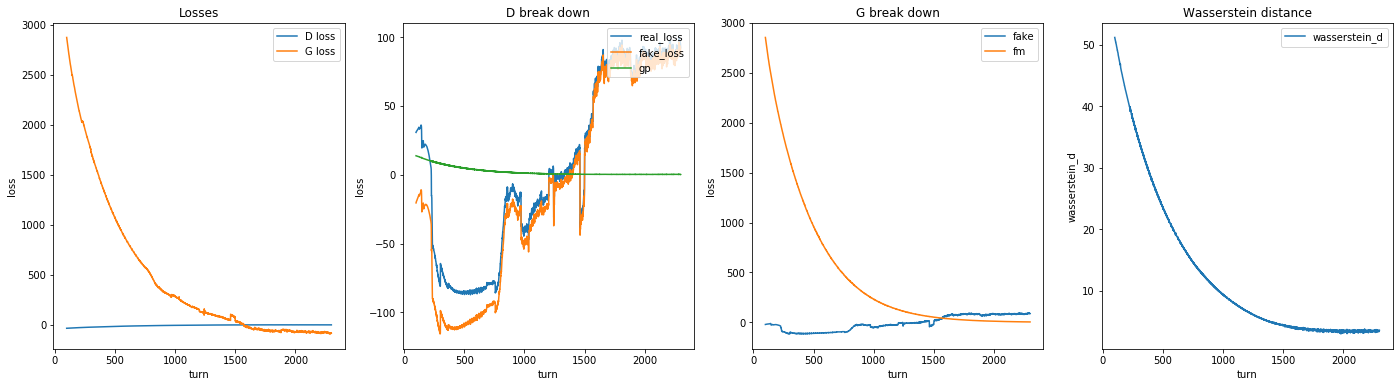

In [20]:
show_status_graph_wgan_gp(status_dict, burn_in=50, holizon=True)

生成データの画像を表示

10 images found in ../datasets/theorytab/midinet/learning/midinetw
00: fake_samples_epoch050.png
01: fake_samples_epoch100.png
02: fake_samples_epoch150.png
03: fake_samples_epoch200.png
04: fake_samples_epoch250.png
05: fake_samples_epoch300.png
06: fake_samples_epoch350.png
07: fake_samples_epoch400.png
08: fake_samples_epoch450.png
09: fake_samples_epoch500.png
input the number of image:9


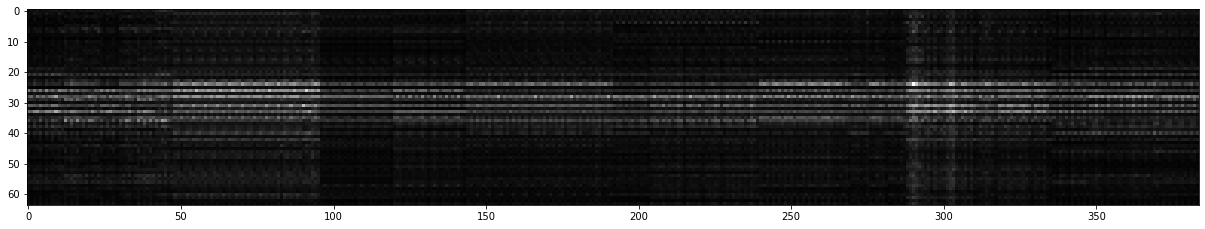

In [18]:
image_paths = glob.glob(os.path.join(save_dir, "fake_samples_*"))
image_paths.sort()

print(f"{len(image_paths)} images found in {save_dir}")
for i, path in enumerate(image_paths):
    print(f"{i:02}: {path.split('/')[-1]}")

image_path = image_paths[int(input("input the number of image:"))]

img = np.array(Image.open(image_path))
fig, ax = plt.subplots(figsize=(21, 7))
ax.imshow(img)

WGAN-gpで500epoch, 収束はしているが，パープレキシティが高い

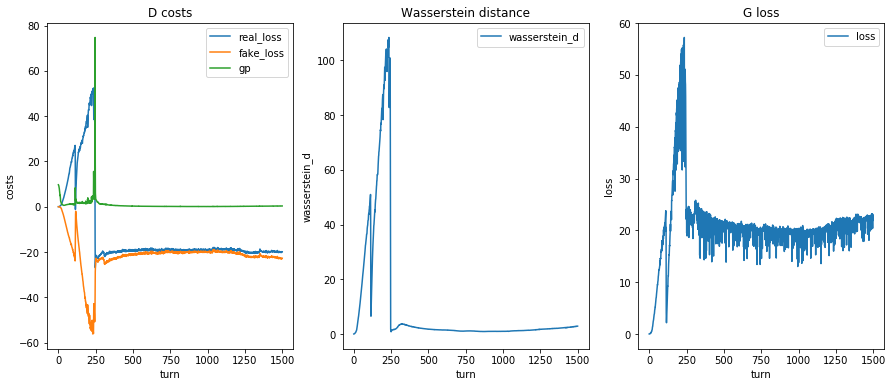

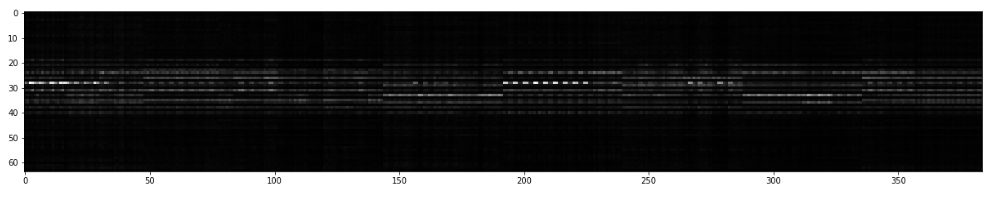

Feature Matching (G) で500epochしてみた  
しかしまだまともじゃない...  
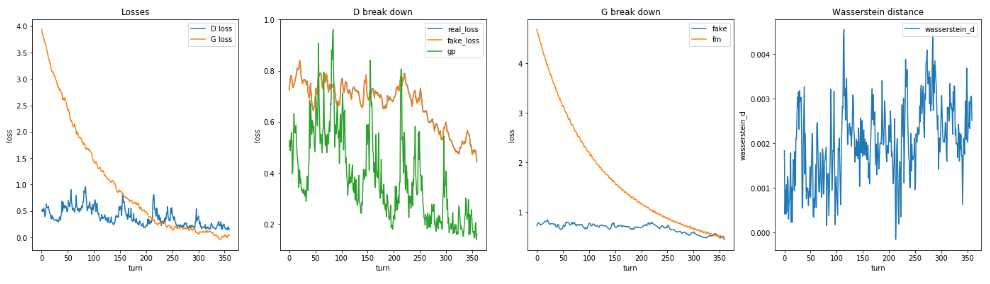

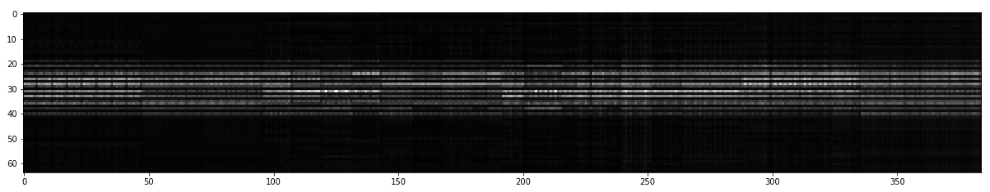

dtt:gtt=3:1で500Epoch  
もうちょっと頑張ればマシになる？  
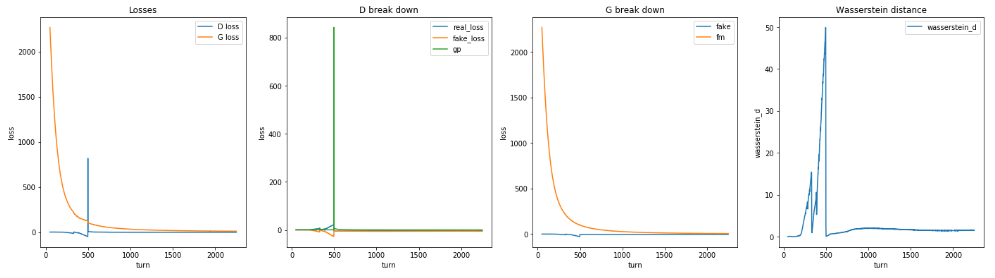

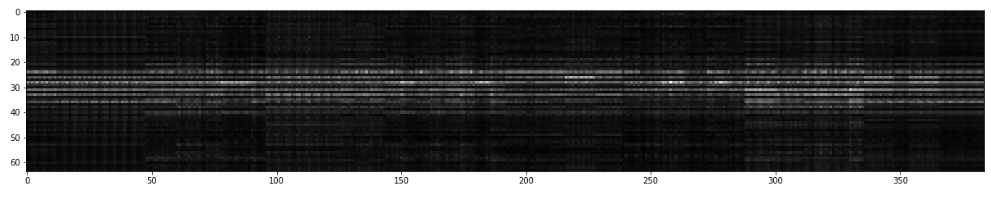

Adaptive GANで360Epoch  
これ以上はGTTが最大の60のまま  
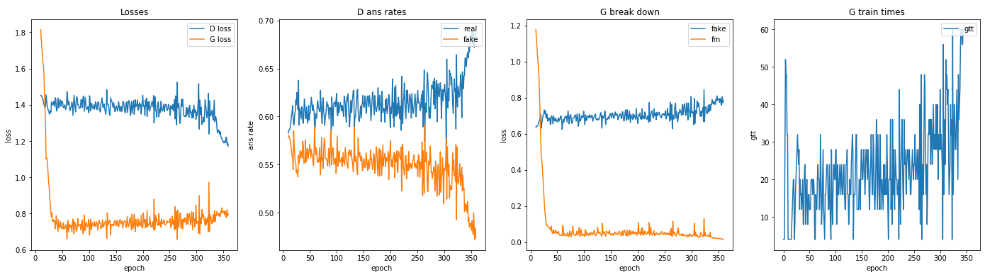

Adaptive GANってなんでこんなに効くんだ？  
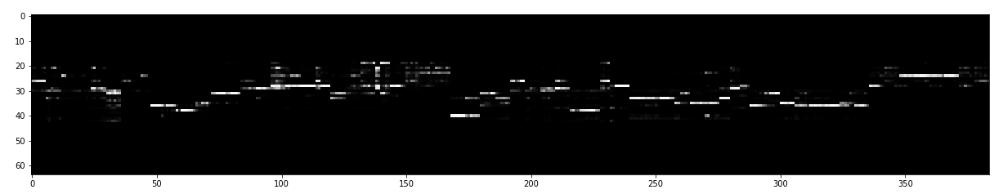

AdamからRMSpropにしてDのbatch_normを取り除き，ハイパーパラメータを[オリジナル](https://github.com/caogang/wgan-gp)と同様に調整したもの  
WDはめちゃくちゃ安定する  
  
安定はするけど出力マップはぼやける．何故？  
WGAN-gpは全体の特徴をうまくとらえることはできるけど，局所的な特徴を捉えられない？  
  
同条件で5000Epochすると8時間かかるらしいが，Kernel Deadした．．．  
それでもさっぱり収束しなかったが．．．
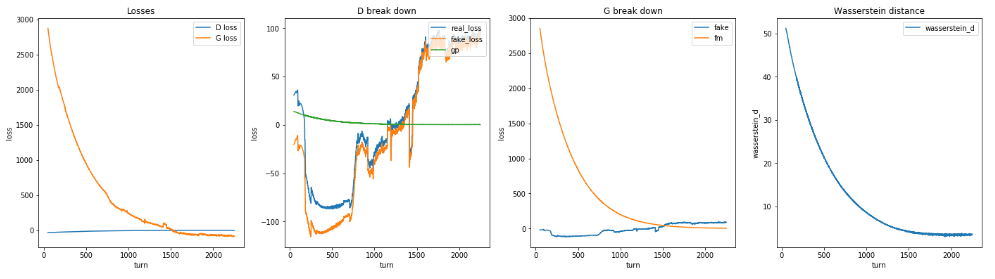

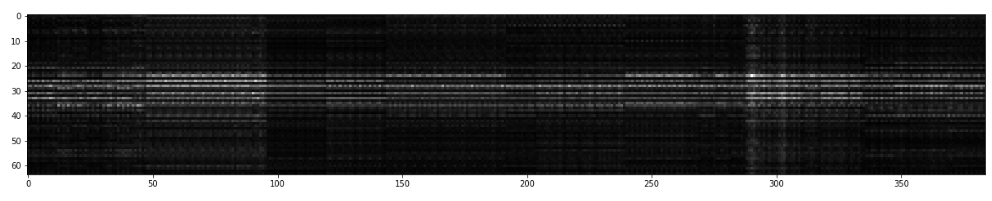